In [4]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [5]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [6]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time > time - 50)] # look at simulations after equilibrium is reached
    tmp["ribo_density_ave"] = tmp[(tmp.species == "cellularProtein")]['ribo_density'].mean()
    tmp = tmp[(tmp.time == time)]
    return tmp

def get_average_protein_no_delta(path, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    #tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [19]:
# simulation parameters 
time_limit = 100
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = 10
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [10000.0, 30000.0, 100000.0, 300000.0, 1000000.0, 3000000.0]
trna_charging_rates = [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
ecol_mrna_composition = (0.7, 0.3) 
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
ribosome_footprint = 15

#ribosome_speeds = [0.5, 1, 2, 4, 8]
ribosome_speeds = [8]
date = "april-9-2024"
yaml_ext = 8

In [17]:
!mkdir ../output/april-9-2024-0.5
!mkdir ../output/april-9-2024-1
!mkdir ../output/april-9-2024-2
!mkdir ../output/april-9-2024-4
!mkdir ../output/april-9-2024-8

!mkdir ../yaml/april-9-2024

mkdir: cannot create directory ‘../output/april-9-2024-0.5’: File exists
mkdir: cannot create directory ‘../output/april-9-2024-1’: File exists
mkdir: cannot create directory ‘../output/april-9-2024-2’: File exists
mkdir: cannot create directory ‘../output/april-9-2024-4’: File exists
mkdir: cannot create directory ‘../yaml/april-9-2024’: File exists


In [21]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}-{yaml_ext}.txt", "w") as stream:
    for config in configs:
        for speed in ribosome_speeds:
            for binding_rate in ribosome_binding_rates:
                for charging_rate in trna_charging_rates:
                    for seed in range(1, 4):
                        cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
                          f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {charging_rate} {charging_rate} " + \
                          f"../output/{date}-{speed} {speed} {ribosome_footprint}"
                        stream.write(cmd)
                        stream.write("\n")

In [9]:
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
df_master = None

for speed in ribosome_speeds:
    df_speed = None
    for charging_rate in trna_charging_rates:
        df_charge = None
        for binding_rate in ribosome_binding_rates:
            df_binding = None
            for codons in gfp_mrna_compositions:
                path = f"../output/{date}-{speed}/two_codon_multi_transcript_0.7_0.3_{codons[0]}_{codons[1]}_0.7_0.3" + \
                       f"_{cellular_transcript_copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                       f"_{ecol_rbs_rate}_{binding_rate}_{charging_rate}_{charging_rate}"
                tmp = get_average_protein(path, 0.5, 100, 3)
                tmp["codon"] = float(codons[0])
                tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
                if df_binding is not None:
                    df_binding = df_binding.append(tmp, ignore_index=True)
                else:
                    df_binding = tmp
            df_binding["gfp_rbs"] = binding_rate
            if df_charge is not None:
                df_charge = df_charge.append(df_binding, ignore_index=True)
            else:
                df_charge = df_binding
        df_charge["charging_rate"] = charging_rate
        if df_speed is not None:
            df_speed = df_speed.append(df_charge, ignore_index=True)
        else:
            df_speed = df_charge
    df_speed["speed"] = speed
    if df_master is not None:
        df_master = df_master.append(df_speed, ignore_index=True)
    else:
        df_master = df_speed
    

df_master = df_master[(df_master.time == 100.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_2939158/3085634170.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()


In [10]:
df_master

,time,species,protein,ribo_density,delta,ribo_density_ave,codon,gfp_rbs,charging_rate,speed
0,100.0,ATA_charged,42.000000,0.000000,0.666667,4.895333,0.9,10000.0,10.0,0.5
1,100.0,ATA_uncharged,708.000000,0.000000,-0.666667,4.895333,0.9,10000.0,10.0,0.5
2,100.0,GFP,5.666667,0.000000,2.333333,4.895333,0.9,10000.0,10.0,0.5
3,100.0,TTT_charged,210.666667,0.000000,14.666667,4.895333,0.9,10000.0,10.0,0.5
4,100.0,TTT_uncharged,1539.333333,0.000000,-14.666667,4.895333,0.9,10000.0,10.0,0.5
...,...,...,...,...,...,...,...,...,...,...
7555,100.0,TTT_uncharged,53.333333,0.000000,-1.000000,1.465333,0.1,3000000.0,10000.0,4.0
7556,100.0,__GFP_rbs,9.666667,0.000000,0.000000,1.465333,0.1,3000000.0,10000.0,4.0
7557,100.0,__cellularProtein_rbs,99.333333,0.000000,0.000000,1.465333,0.1,3000000.0,10000.0,4.0
7558,100.0,free ribosome,331.000000,0.000000,9.666667,1.465333,0.1,3000000.0,10000.0,4.0


In [43]:
df_master["gfp_rbs_foldx"] = df_master["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df_master.pivot_table(index=['gfp_rbs_foldx', 'codon', 'charging_rate', "speed"], columns='species', values='protein').reset_index()

df["TTT_charged_perc"] = df["TTT_charged"] / (total_trna*0.7)
df["ATA_charged_perc"] = df["ATA_charged"] / (total_trna*0.3)
df["free_ribosome_perc"] = df["free ribosome"] / ribosome_copy_number

df['cellularProtein_max'] = df.groupby(['codon', 'charging_rate', "speed"])['cellularProtein'].transform('max')
df['cellularProtein_norm'] = df['cellularProtein']/df["cellularProtein_max"]

#df['ATA_charged_max'] = df.groupby(['codon', 'charging_rate', "speed"])['ATA_charged'].transform('max')
#df['ATA_charged_norm'] = df['ATA_charged']/df["ATA_charged_max"]
#df['TTT_charged_max'] = df.groupby(['codon', 'charging_rate', "speed"])['TTT_charged'].transform('max')
#df['TTT_charged_norm'] = df['TTT_charged']/df["TTT_charged_max"]

df = df.rename_axis("index", axis=1).reset_index(drop=True)
df

index,gfp_rbs_foldx,codon,charging_rate,speed,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,TTT_charged_perc,ATA_charged_perc,free_ribosome_perc,cellularProtein_max,cellularProtein_norm
0,0.1,0.1,10.0,0.5,39.333333,710.666667,4.666667,186.666667,1563.333333,10.000000,100.000000,2000.333333,1.000000,0.106667,0.052444,0.002000,2002.000000,0.999167
1,0.1,0.1,10.0,1.0,17.333333,732.666667,4.666667,206.000000,1544.000000,10.000000,97.333333,2040.000000,6.333333,0.117714,0.023111,0.012667,2043.666667,0.998206
2,0.1,0.1,10.0,2.0,10.666667,739.333333,3.333333,200.666667,1549.333333,10.000000,98.000000,2078.333333,7.333333,0.114667,0.014222,0.014667,2078.333333,1.000000
3,0.1,0.1,10.0,4.0,4.333333,745.666667,3.000000,128.000000,1622.000000,10.000000,99.000000,2095.333333,6.666667,0.073143,0.005778,0.013333,2098.000000,0.998729
4,0.1,0.1,30.0,0.5,141.333333,608.666667,7.666667,396.333333,1353.666667,10.000000,95.666667,5649.666667,24.333333,0.226476,0.188444,0.048667,5649.666667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,30.0,0.9,3000.0,4.0,682.666667,67.333333,20279.666667,1587.666667,162.333333,10.000000,99.666667,68838.333333,335.333333,0.907238,0.910222,0.670667,70466.333333,0.976897
836,30.0,0.9,10000.0,0.5,744.000000,6.000000,6384.000000,1730.333333,19.666667,9.333333,98.000000,22202.333333,115.000000,0.988762,0.992000,0.230000,23353.000000,0.950727
837,30.0,0.9,10000.0,1.0,735.000000,15.000000,10548.333333,1725.666667,24.333333,9.333333,98.000000,36473.666667,173.000000,0.986095,0.980000,0.346000,38040.666667,0.958807
838,30.0,0.9,10000.0,2.0,733.333333,16.666667,15610.666667,1709.666667,40.333333,9.333333,98.000000,53759.000000,264.333333,0.976952,0.977778,0.528667,55343.000000,0.971378


In [54]:
speed = 0.5
charging_rate = 300.0
binding_rate = 10000.0

path = f"../output/{date}-{speed}/two_codon_multi_transcript_0.7_0.3_0.9_0.1_0.7_0.3" + \
        f"_{cellular_transcript_copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
        f"_{ecol_rbs_rate}_{binding_rate}_{charging_rate}_{charging_rate}"

df_exp = get_average_protein_no_delta(path, 3)
df_exp["species"] = df_exp["species"].replace({"__ribosome": "free ribosome"})

df_exp

,time,species,protein
0,0.0,ATA_charged,750.000000
1,0.0,ATA_uncharged,0.000000
2,0.0,TTT_charged,1750.000000
3,0.0,TTT_uncharged,0.000000
4,0.0,__GFP_rbs,10.000000
...,...,...,...
182,100.0,TTT_uncharged,441.333333
183,100.0,__GFP_rbs,10.000000
184,100.0,__cellularProtein_rbs,97.666667
185,100.0,free ribosome,104.333333


In [55]:
df_exp.to_csv("steady_states.csv")

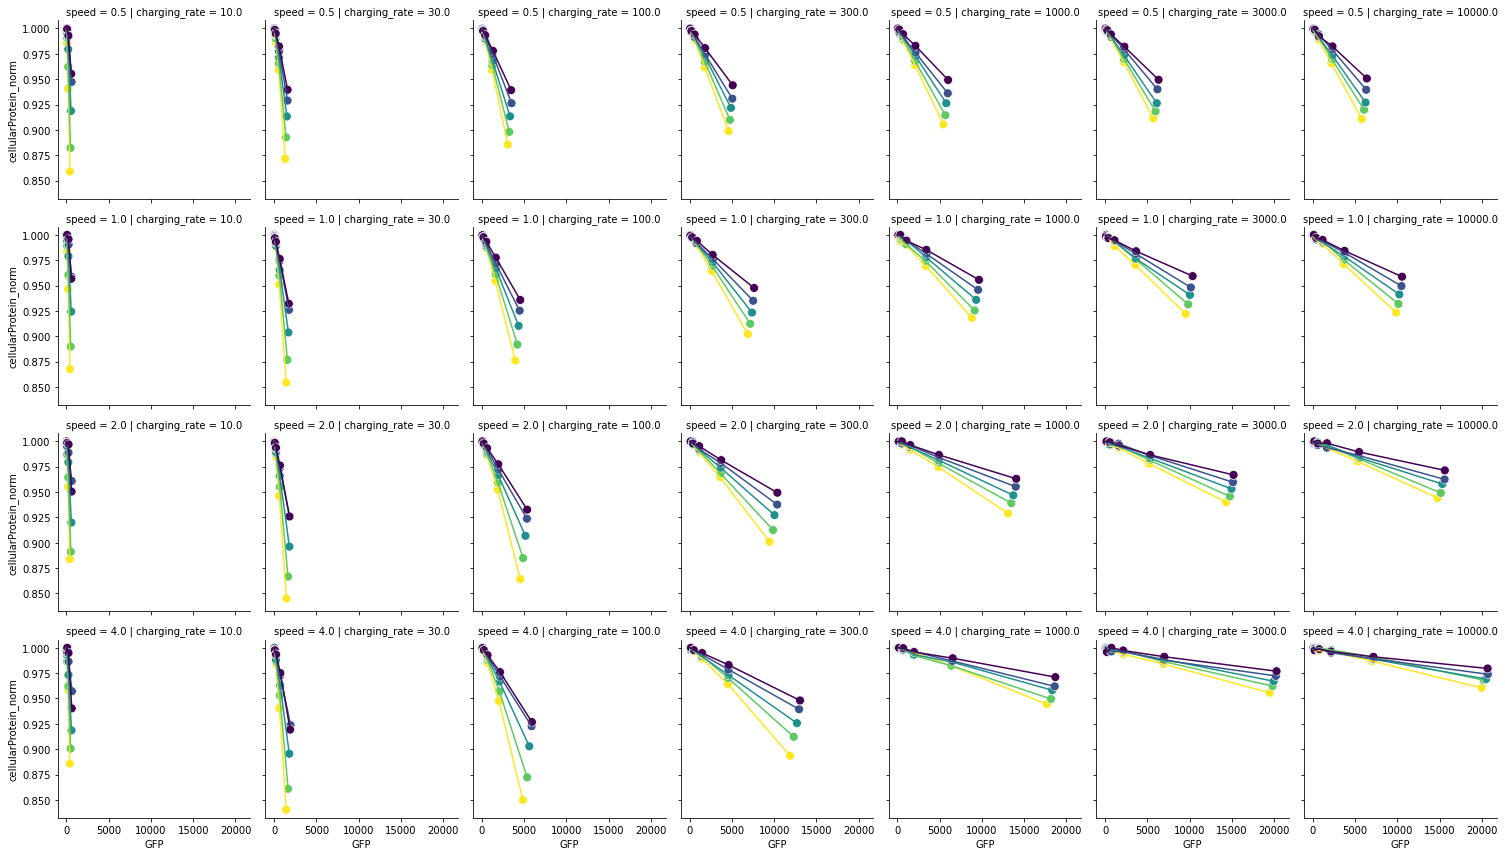

In [62]:
g = sns.FacetGrid(df, col="charging_rate", row="speed")
g.map_dataframe(sns.scatterplot, x="GFP", y="cellularProtein_norm", hue = "codon", s=80, palette="viridis_r")
g.map_dataframe(sns.lineplot, x="GFP", y="cellularProtein_norm", hue = "codon", palette="viridis_r")

In [45]:
df.to_csv("gfp_regression_speed.csv")

In [10]:
df_rib = df_master.pivot_table(index=['gfp_rbs_foldx', 'codon', 'charging_rate', "speed"], columns='species', values='ribo_density').reset_index()
df_rib

species,gfp_rbs_foldx,codon,charging_rate,speed,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome
0,0.1,0.1,10.0,0.5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.990000,0.0
1,0.1,0.1,10.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.936667,0.0
2,0.1,0.1,10.0,2.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,4.923333,0.0
3,0.1,0.1,10.0,4.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.933333,0.0
4,0.1,0.1,30.0,0.5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.756667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,30.0,0.9,3000.0,4.0,0.0,0.0,1.066667,0.0,0.0,0.0,0.0,1.540000,0.0
836,30.0,0.9,10000.0,0.5,0.0,0.0,2.333333,0.0,0.0,0.0,0.0,3.616667,0.0
837,30.0,0.9,10000.0,1.0,0.0,0.0,2.500000,0.0,0.0,0.0,0.0,3.020000,0.0
838,30.0,0.9,10000.0,2.0,0.0,0.0,1.333333,0.0,0.0,0.0,0.0,2.223333,0.0


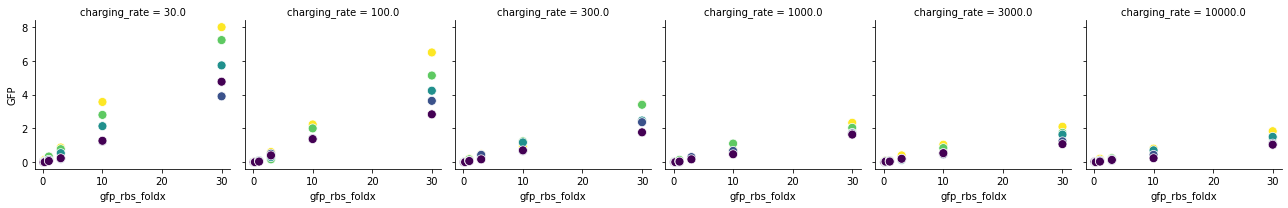

In [87]:
g = sns.FacetGrid(df_rib[(df_rib.speed == 4) & (df.charging_rate > 10.0)], col="charging_rate", sharey=True)
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="GFP", hue="codon",  s=80, palette="viridis_r")

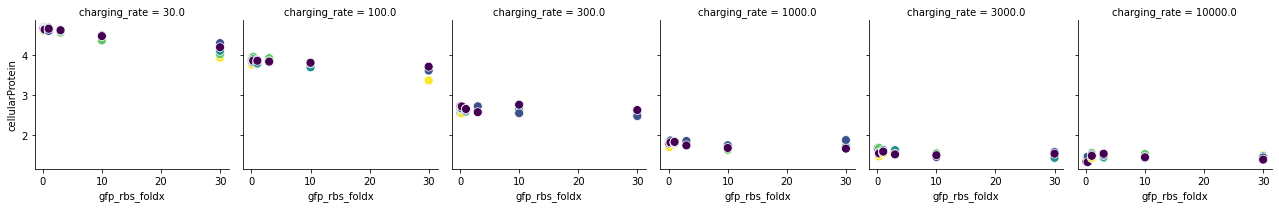

In [90]:
g = sns.FacetGrid(df_rib[(df_rib.speed == 4) & (df.charging_rate > 10.0)], col="charging_rate", sharey=True)
g.map_dataframe(sns.scatterplot, x="gfp_rbs_foldx", y="cellularProtein", hue="codon",  s=80, palette="viridis_r")

In [87]:
# simulation parameters 
time_limit = 100
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = 10
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [10000.0, 30000.0, 100000.0, 300000.0, 1000000.0, 3000000.0]
trna_charging_rates = [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.3, 0.7), (0.1, 0.9)]
ribosome_speed = 2
ribosome_footprint = 15

#ecol_mrna_compositions = [(0.72, 0.28)]
#ecol_mrna_compositions = [(0.73, 0.27)]
ecol_mrna_compositions = [(0.2, 0.8), (0.4, 0.6), (0.6, 0.4), (0.72, 0.28), (0.73, 0.27), (0.8, 0.2), (1.0, 0)]
date = "april-19-2024"
date_y = "april-19-2024-b"
date_y2 = "april-19-2024-c"

In [83]:
!mkdir ../output/april-19-2024
!mkdir ../yaml/april-19-2024
!mkdir ../yaml/april-19-2024-b
!mkdir ../yaml/april-19-2024-c

mkdir: cannot create directory ‘../output/april-19-2024’: File exists
mkdir: cannot create directory ‘../yaml/april-19-2024’: File exists
mkdir: cannot create directory ‘../yaml/april-19-2024-b’: File exists


In [86]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        for ecol in ecol_mrna_compositions:
            serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                           codon_comps=[ecol, comp],
                                                           trna_proportion=trna_prop,
                                                           transcript_names=transcript_names,
                                                           time_limit=time_limit,
                                                           time_step=time_step)
            serializer.serialize(f"../yaml/{date_y2}")
        
configs = os.listdir(f"../yaml/{date_y2}")
with open(f"../scripts/cmd_files/{date}-c.txt", "w") as stream:
    for config in configs:
        for binding_rate in ribosome_binding_rates:
            for charging_rate in trna_charging_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date_y2}/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {charging_rate} {charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [88]:
df_master = None

for ecol_codons in ecol_mrna_compositions:
    df_ecol = None
    for charging_rate in trna_charging_rates:
        df_charge = None
        for binding_rate in ribosome_binding_rates:
            df_binding = None
            for codons in gfp_mrna_compositions:
                path = f"../output/{date}/two_codon_multi_transcript_{ecol_codons[0]}_{ecol_codons[1]}_{codons[0]}_{codons[1]}_0.7_0.3" + \
                       f"_{cellular_transcript_copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                       f"_{ecol_rbs_rate}_{binding_rate}_{charging_rate}_{charging_rate}"
                tmp = get_average_protein(path, 0.5, 100, 3)
                tmp["codon"] = float(codons[0])
                tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
                if df_binding is not None:
                    df_binding = df_binding.append(tmp, ignore_index=True)
                else:
                    df_binding = tmp
            df_binding["gfp_rbs"] = binding_rate
            if df_charge is not None:
                df_charge = df_charge.append(df_binding, ignore_index=True)
            else:
                df_charge = df_binding
        df_charge["charging_rate"] = charging_rate
        if df_ecol is not None:
            df_ecol = df_ecol.append(df_charge, ignore_index=True)
        else:
            df_ecol = df_charge
    df_ecol["ecol"] = ecol_codons[0]
    if df_master is not None:
        df_master = df_master.append(df_ecol, ignore_index=True)
    else:
        df_master = df_ecol
    

df_master = df_master[(df_master.time == 100.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_994361/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()


In [76]:
df_master

,time,species,protein,ribo_density,delta,codon,gfp_rbs,charging_rate,ecol
9,100.0,ATA_charged,7.666667,0.000000,-0.333333,0.9,10000.0,10.0,0.2
10,100.0,ATA_uncharged,742.333333,0.000000,0.333333,0.9,10000.0,10.0,0.2
11,100.0,GFP,2.000000,0.000000,0.333333,0.9,10000.0,10.0,0.2
12,100.0,TTT_charged,1567.000000,0.000000,-5.000000,0.9,10000.0,10.0,0.2
13,100.0,TTT_uncharged,183.000000,0.000000,5.000000,0.9,10000.0,10.0,0.2
...,...,...,...,...,...,...,...,...,...
22675,100.0,TTT_uncharged,60.000000,0.000000,7.666667,0.1,3000000.0,10000.0,1.0
22676,100.0,__GFP_rbs,10.000000,0.000000,0.666667,0.1,3000000.0,10000.0,1.0
22677,100.0,__cellularProtein_rbs,99.666667,0.000000,1.666667,0.1,3000000.0,10000.0,1.0
22678,100.0,free ribosome,277.666667,0.000000,-24.333333,0.1,3000000.0,10000.0,1.0


In [89]:
df_master["gfp_rbs_foldx"] = df_master["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df_master.pivot_table(index=['gfp_rbs_foldx', 'codon', 'charging_rate', "ecol"], columns='species', values='protein').reset_index()

df["TTT_charged_perc"] = df["TTT_charged"] / (total_trna*0.7)
df["ATA_charged_perc"] = df["ATA_charged"] / (total_trna*0.3)
df["free_ribosome_perc"] = df["free ribosome"] / ribosome_copy_number

df['cellularProtein_max'] = df.groupby(['codon', 'charging_rate', "ecol"])['cellularProtein'].transform('max')
df['cellularProtein_norm'] = df['cellularProtein']/df["cellularProtein_max"]

#df['ATA_charged_max'] = df.groupby(['codon', 'charging_rate', "speed"])['ATA_charged'].transform('max')
#df['ATA_charged_norm'] = df['ATA_charged']/df["ATA_charged_max"]
#df['TTT_charged_max'] = df.groupby(['codon', 'charging_rate', "speed"])['TTT_charged'].transform('max')
#df['TTT_charged_norm'] = df['TTT_charged']/df["TTT_charged_max"]

df = df.rename_axis("index", axis=1).reset_index(drop=True)
df

index,gfp_rbs_foldx,codon,charging_rate,ecol,ATA_charged,ATA_uncharged,GFP,TTT_charged,TTT_uncharged,__GFP_rbs,__cellularProtein_rbs,cellularProtein,free ribosome,TTT_charged_perc,ATA_charged_perc,free_ribosome_perc,cellularProtein_max,cellularProtein_norm
0,0.1,0.1,10.0,0.20,8.666667,741.333333,2.333333,1561.000000,189.000000,10.000000,98.333333,522.000000,5.000000,0.892000,0.011556,0.010000,524.000000,0.996183
1,0.1,0.1,10.0,0.40,9.000000,741.000000,2.666667,1413.333333,336.666667,10.000000,100.000000,1000.000000,0.333333,0.807619,0.012000,0.000667,1000.000000,1.000000
2,0.1,0.1,10.0,0.60,6.666667,743.333333,2.666667,621.000000,1129.000000,10.000000,97.333333,1518.333333,3.333333,0.354857,0.008889,0.006667,1518.333333,1.000000
3,0.1,0.1,10.0,0.72,54.333333,695.666667,3.333333,20.333333,1729.666667,10.000000,95.666667,2083.000000,9.666667,0.011619,0.072444,0.019333,2088.666667,0.997287
4,0.1,0.1,10.0,0.73,104.000000,646.000000,4.000000,20.000000,1730.000000,10.000000,97.333333,2044.000000,7.666667,0.011429,0.138667,0.015333,2050.333333,0.996911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,30.0,0.9,10000.0,0.60,729.333333,20.666667,15044.666667,1714.000000,36.000000,9.666667,98.000000,51383.333333,255.000000,0.979429,0.972444,0.510000,52988.666667,0.969704
1466,30.0,0.9,10000.0,0.72,735.333333,14.666667,15785.333333,1710.000000,40.000000,9.333333,98.666667,54285.666667,265.666667,0.977143,0.980444,0.531333,56002.333333,0.969347
1467,30.0,0.9,10000.0,0.73,730.000000,20.000000,15822.333333,1708.333333,41.666667,9.666667,98.666667,54593.666667,270.000000,0.976190,0.973333,0.540000,56209.666667,0.971250
1468,30.0,0.9,10000.0,0.80,740.666667,9.333333,16397.333333,1699.333333,50.666667,9.666667,98.666667,56272.000000,267.333333,0.971048,0.987556,0.534667,58006.333333,0.970101


In [90]:
df.to_csv("gfp_regression_ecol_codon_use.csv")

In [11]:
# simulation parameters 
time_limit = 100
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = 10
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [0.000001]
trna_charging_rates = [10.0, 100.0, 1000.0, 10000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 2
#ribosome_footprint = 15
ribosome_footprint = 5

ecol_mrna_compositions = [(x/100, round(1 - x/100, 2)) for x in range(2, 100, 2)]
date = "april-28-2024"

In [52]:
!mkdir ../output/april-28-2024
!mkdir ../yaml/april-28-2024

In [91]:
!mkdir ../yaml/april-28-2024-b

In [96]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        for ecol in ecol_mrna_compositions:
            serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                           codon_comps=[ecol, comp],
                                                           trna_proportion=trna_prop,
                                                           transcript_names=transcript_names,
                                                           time_limit=time_limit,
                                                           time_step=time_step)
            serializer.serialize(f"../yaml/{date}-b")
        
configs = os.listdir(f"../yaml/{date}-b")
with open(f"../scripts/cmd_files/{date}-b.txt", "w") as stream:
    for config in configs:
        for binding_rate in ribosome_binding_rates:
            for charging_rate in trna_charging_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}-b/{config} {seed} {cellular_transcript_copy_number} {gfp_transcript_copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {charging_rate} {charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [12]:
df_master = None

for ecol_codons in ecol_mrna_compositions:
    df_ecol = None
    for charging_rate in trna_charging_rates:
        df_charge = None
        for binding_rate in ribosome_binding_rates:
            df_binding = None
            for codons in gfp_mrna_compositions:
                path = f"../output/{date}/two_codon_multi_transcript_{ecol_codons[0]}_{ecol_codons[1]}_{codons[0]}_{codons[1]}_0.7_0.3" + \
                       f"_{cellular_transcript_copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                       f"_{ecol_rbs_rate}_{binding_rate}_{charging_rate}_{charging_rate}"
                tmp = get_average_protein(path, 0.5, 100, 3)
                tmp["codon"] = float(codons[0])
                tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
                if df_binding is not None:
                    df_binding = df_binding.append(tmp, ignore_index=True)
                else:
                    df_binding = tmp
            df_binding["gfp_rbs"] = binding_rate
            if df_charge is not None:
                df_charge = df_charge.append(df_binding, ignore_index=True)
            else:
                df_charge = df_binding
        df_charge["charging_rate"] = charging_rate
        if df_ecol is not None:
            df_ecol = df_ecol.append(df_charge, ignore_index=True)
        else:
            df_ecol = df_charge
    df_ecol["ecol"] = ecol_codons[0]
    if df_master is not None:
        df_master = df_master.append(df_ecol, ignore_index=True)
    else:
        df_master = df_ecol
    

df_master = df_master[(df_master.time == 100.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_2939158/3085634170.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()


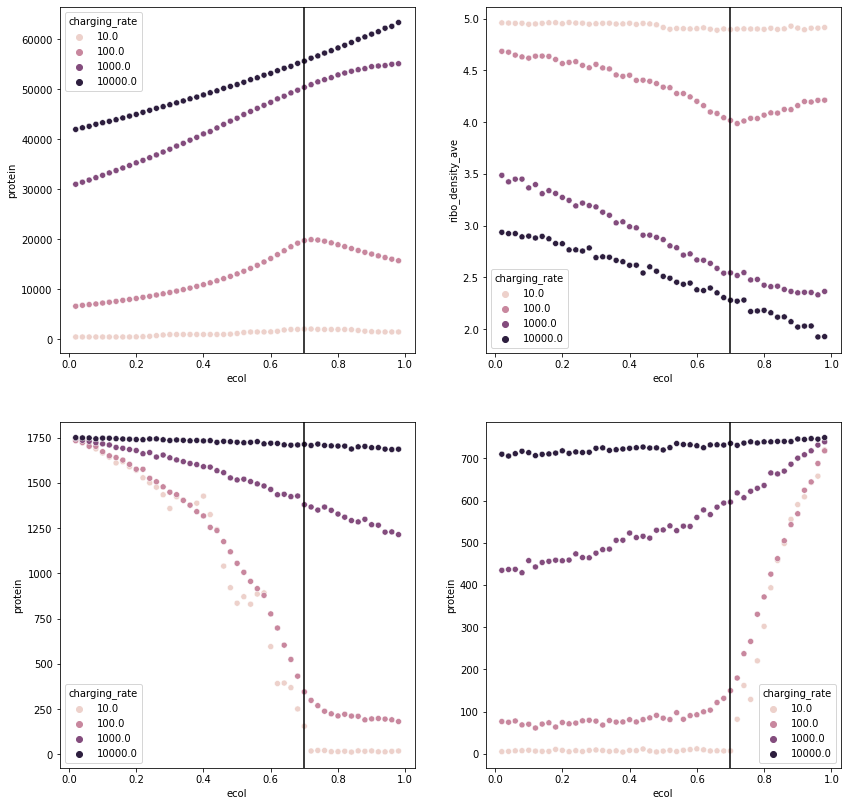

In [13]:
rcParams['figure.figsize'] = [14, 14]
norm = LogNorm()
#df_cell = df_master[(df_master.species == "cellularProtein") & (df_master.charging_rate == 100.0)]
fig, ax = plt.subplots(2, 2)
df_cell = df_master[(df_master.species == "cellularProtein")]
g1 = sns.scatterplot(data=df_cell, x="ecol", y="protein", ax=ax[0][0], hue="charging_rate", hue_norm=norm)
g1.axvline(x=0.7, color="black")

g2 = sns.scatterplot(data=df_cell, x="ecol", y="ribo_density_ave", ax=ax[0][1], hue="charging_rate", hue_norm=norm)
g2.axvline(x=0.7, color="black")

df_tt = df_master[(df_master.species == "TTT_charged")]
g3 = sns.scatterplot(data=df_tt, x="ecol", y="protein", ax=ax[1][0], hue="charging_rate", hue_norm=norm)
g3.axvline(x=0.7, color="black")

df_at = df_master[(df_master.species == "ATA_charged")]
g4 = sns.scatterplot(data=df_at, x="ecol", y="protein", ax=ax[1][1], hue="charging_rate", hue_norm=norm)
g4.axvline(x=0.7, color="black")

In [14]:
df_master.to_csv("cell_expression_no_gfp.csv")

In [161]:
df_master[(df_master.charging_rate == 100.0) & (df_master.ecol == 0.7)]

,time,species,protein,ribo_density,delta,ribo_density_ave,codon,gfp_rbs,charging_rate,ecol
1096,100.0,ATA_charged,149.666667,0.000000,-5.000000,4.015667,0.7,0.000001,100.0,0.7
1097,100.0,ATA_uncharged,600.333333,0.000000,5.000000,4.015667,0.7,0.000001,100.0,0.7
1098,100.0,TTT_charged,345.333333,0.000000,-0.333333,4.015667,0.7,0.000001,100.0,0.7
1099,100.0,TTT_uncharged,1404.666667,0.000000,0.333333,4.015667,0.7,0.000001,100.0,0.7
1100,100.0,__GFP_rbs,10.000000,0.000000,0.000000,4.015667,0.7,0.000001,100.0,0.7
1101,100.0,__cellularProtein_rbs,98.666667,0.000000,-1.333333,4.015667,0.7,0.000001,100.0,0.7
1102,100.0,free ribosome,91.666667,0.000000,-8.333333,4.015667,0.7,0.000001,100.0,0.7
1103,100.0,cellularProtein,19750.333333,4.083333,7989.666667,4.015667,0.7,0.000001,100.0,0.7
